In [1]:
# --- Differentiable PC-MRI encoder/decoder (PyTorch) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


In [2]:

def _as_torch(x, device, dtype=torch.float32):
    return torch.as_tensor(x, device=device, dtype=dtype)

def complex_noise(shape, std, device, dtype=torch.complex64):
    if std <= 0: 
        return torch.zeros(shape, device=device, dtype=dtype)
    # complex Gaussian: N(0, std^2/2) + i N(0, std^2/2)
    n_real = torch.randn(shape, device=device) * (std / math.sqrt(2.0))
    n_imag = torch.randn(shape, device=device) * (std / math.sqrt(2.0))
    return torch.complex(n_real, n_imag).to(dtype)

def angle(z):
    # Differentiable phase: atan2(Im, Re)
    return torch.atan2(z.imag, z.real)

class PCMRIEncoder(nn.Module):
    """
    Differentiable ±VENC PC-MRI encoder.
    Input:  vel  (B, T, 2, H, W)  with channels [u_x, u_y] in m/s (or sim units)
    Params: venc_x, venc_y  (float or broadcastable tensor)
    Output: dict with complex encodes and phase-difference maps (all differentiable)
    """
    def __init__(self, venc_x=1.0, venc_y=1.0, noise_std=0.0, dtype=torch.complex64):
        super().__init__()
        # store as buffers so they move with .to(device)
        self.register_buffer("venc_x", torch.tensor(float(venc_x)))
        self.register_buffer("venc_y", torch.tensor(float(venc_y)))
        self.noise_std = float(noise_std)
        self.cdtype = dtype  # complex dtype

    def forward(self, vel):
        """
        vel: (B,T,2,H,W) -> returns dict with:
          Sx_pos,Sx_neg,Sy_pos,Sy_neg : complex (B,T,H,W)
          dphi_x,dphi_y               : real    (B,T,H,W) in [-pi,pi]
        """
        assert vel.ndim == 5 and vel.size(2) == 2, "vel must be (B,T,2,H,W) with channels [u_x,u_y]"
        device = vel.device
        ux = vel[:, :, 0]  # (B,T,H,W)
        uy = vel[:, :, 1]

        # broadcast venc across batch/time/space
        vx = self.venc_x.to(device)  # scalar/buffer
        vy = self.venc_y.to(device)

        # phases
        phi_x = math.pi * (ux / vx)
        phi_y = math.pi * (uy / vy)

        # complex encodes
        Sx_pos = torch.exp(1j * phi_x).to(self.cdtype)
        Sx_neg = torch.exp(-1j * phi_x).to(self.cdtype)
        Sy_pos = torch.exp(1j * phi_y).to(self.cdtype)
        Sy_neg = torch.exp(-1j * phi_y).to(self.cdtype)

        # optional complex noise (scanner noise)
        if self.noise_std > 0:
            Sx_pos = Sx_pos + complex_noise(Sx_pos.shape, self.noise_std, device, self.cdtype)
            Sx_neg = Sx_neg + complex_noise(Sx_neg.shape, self.noise_std, device, self.cdtype)
            Sy_pos = Sy_pos + complex_noise(Sy_pos.shape, self.noise_std, device, self.cdtype)
            Sy_neg = Sy_neg + complex_noise(Sy_neg.shape, self.noise_std, device, self.cdtype)

        # phase-difference (wrapped)
        dphi_x = angle(Sx_pos * torch.conj(Sx_neg))   # (B,T,H,W)
        dphi_y = angle(Sy_pos * torch.conj(Sy_neg))

        return {
            "Sx_pos": Sx_pos, "Sx_neg": Sx_neg,
            "Sy_pos": Sy_pos, "Sy_neg": Sy_neg,
            "dphi_x": dphi_x, "dphi_y": dphi_y,
        }

class PCMRIDecoder(nn.Module):
    """
    Differentiable decoder for PC-MRI.
    Can take (dphi_x,dphi_y) OR (S±) and returns reconstructed velocities.
    """
    def __init__(self, venc_x=1.0, venc_y=1.0):
        super().__init__()
        self.register_buffer("venc_x", torch.tensor(float(venc_x)))
        self.register_buffer("venc_y", torch.tensor(float(venc_y)))

    def forward(self, *, dphi_x=None, dphi_y=None, Sx_pos=None, Sx_neg=None, Sy_pos=None, Sy_neg=None):
        device = (dphi_x if dphi_x is not None else Sx_pos).device

        if dphi_x is None or dphi_y is None:
            # compute from complex pairs
            assert Sx_pos is not None and Sx_neg is not None and Sy_pos is not None and Sy_neg is not None
            dphi_x = angle(Sx_pos * torch.conj(Sx_neg))
            dphi_y = angle(Sy_pos * torch.conj(Sy_neg))

        ux_hat = (dphi_x / (2.0 * math.pi)) * self.venc_x.to(device)
        uy_hat = (dphi_y / (2.0 * math.pi)) * self.venc_y.to(device)
        # return in shape (B,T,2,H,W)
        vel_hat = torch.stack([ux_hat, uy_hat], dim=2)
        return vel_hat

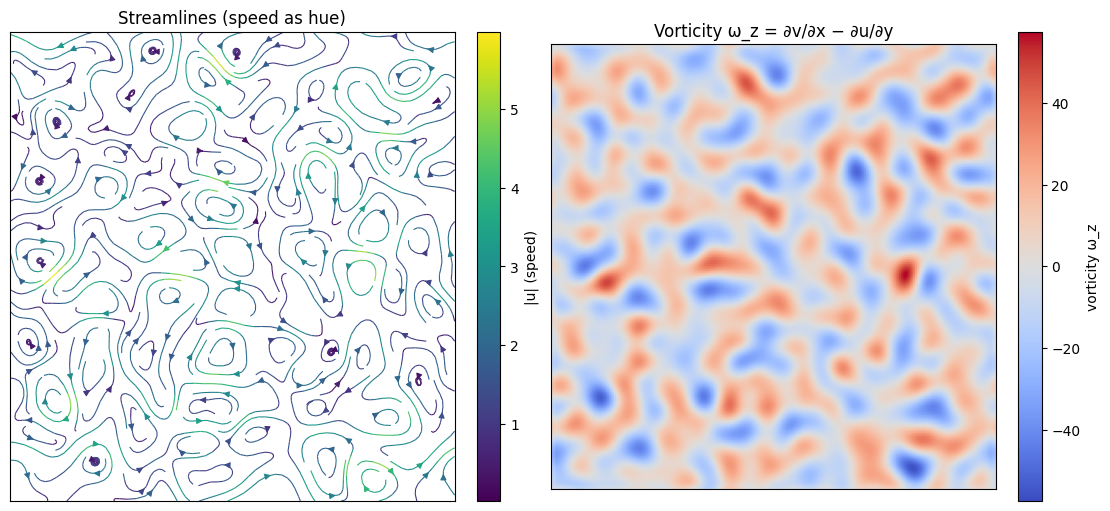

In [3]:
# --- Plot streamlines + vorticity for a 2D incompressible flow ---

import numpy as np
import matplotlib.pyplot as plt

# Reuse existing flow if available; otherwise generate one (same recipe as before)
if all(name in globals() for name in ["flow_u", "flow_v", "flow_x", "flow_y"]):
    u, v, x, y = flow_u, flow_v, flow_x, flow_y
else:
    N = 192
    L = 2*np.pi
    x = np.linspace(0, L, N, endpoint=False)
    y = np.linspace(0, L, N, endpoint=False)
    dx = x[1]-x[0]; dy = y[1]-y[0]

    rng = np.random.default_rng(0)
    noise = rng.normal(size=(N, N))
    kx = np.fft.fftfreq(N, d=1.0/N)[:, None]
    ky = np.fft.fftfreq(N, d=1.0/N)[None, :]
    k2 = kx**2 + ky**2
    sigma_k = 5.0
    lowpass = np.exp(-(k2) / (2*sigma_k**2))
    psi = np.fft.ifft2(np.fft.fft2(noise) * lowpass).real
    dpsi_dy, dpsi_dx = np.gradient(psi, dy, dx)
    u = dpsi_dy
    v = -dpsi_dx
    speed = np.sqrt(u**2 + v**2)
    u /= np.std(speed); v /= np.std(speed)
    flow_u, flow_v, flow_x, flow_y = u, v, x, y  # expose for later use

dx = x[1]-x[0]; dy = y[1]-y[0]
# 2D vorticity: omega_z = ∂v/∂x − ∂u/∂y  (array shape is [y, x])
dv_dx = np.gradient(v, dx, axis=1)
du_dy = np.gradient(u, dy, axis=0)
omega = dv_dx - du_dy

speed = np.sqrt(u**2 + v**2)

# --- Plots ---
fig, axes = plt.subplots(1, 2, figsize=(11, 5), constrained_layout=True, sharex=True, sharey=True)

# Streamlines (speed as hue)
st = axes[0].streamplot(x, y, u, v, color=speed, cmap='viridis', density=1.6, linewidth=0.8, arrowsize=0.9)
fig.colorbar(st.lines, ax=axes[0], label='|u| (speed)')
axes[0].set_title('Streamlines (speed as hue)')

# Vorticity heatmap (symmetric color limits)
omax = np.max(np.abs(omega))
im = axes[1].imshow(omega, origin='lower',
                    extent=[x.min(), x.max(), y.min(), y.max()],
                    cmap='coolwarm', vmin=-omax, vmax=omax)
fig.colorbar(im, ax=axes[1], label='vorticity ω_z')
axes[1].set_title('Vorticity ω_z = ∂v/∂x − ∂u/∂y')

for ax in axes:
    ax.set_xlim(x.min(), x.max()); ax.set_ylim(y.min(), y.max())
    ax.set_xticks([]); ax.set_yticks([])

plt.show()


max|divergence| (spectral) ≈ 6.56e-22


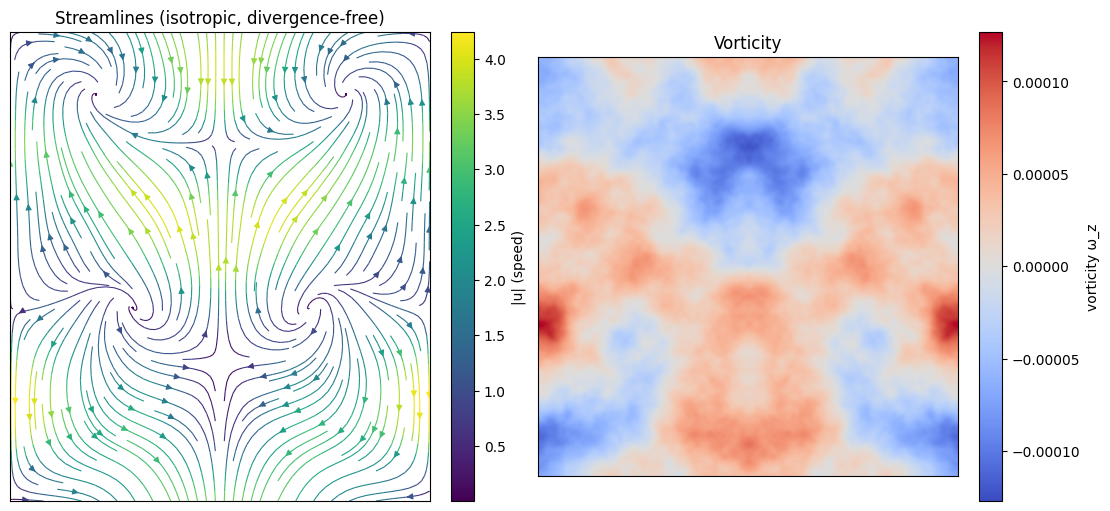

In [4]:
# === Final: clean 2D incompressible snapshot (spectral), with plots & diagnostics ===
import numpy as np
import matplotlib.pyplot as plt

# -------------------
# User knobs
# -------------------
N = 192           # grid size (try 128–512)
L = 2*np.pi       # domain length in x and y
k0 =  1.0          # energy peak scale (larger -> smaller eddies)
p_high = 3.0      # high-k decay ~ k^{-p_high} (≈3 for 2D enstrophy-like)
n_low = 4.0       # low-k rise smoothness
seed = 1          # RNG seed for repeatability

# -------------------
# 1) Grid (periodic) and rFFT wavenumbers (radians/length)
# -------------------
x = np.linspace(0, L, N, endpoint=False)
y = np.linspace(0, L, N, endpoint=False)
dx = L/N; dy = L/N

kx = 2*np.pi * np.fft.fftfreq(N, d=L/N)[:, None]      # shape (N,1)
ky = 2*np.pi * np.fft.rfftfreq(N, d=L/N)[None, :]     # shape (1,N//2+1)
k2 = kx**2 + ky**2
k = np.sqrt(k2, dtype=float)
eps = 1e-12

# -------------------
# 2) Prescribe an isotropic velocity spectrum & 2/3 de-aliasing
# -------------------
kc = (N/3)*(2*np.pi/L)  # componentwise 2/3 cutoff
A_u = (k/k0)**n_low / (1.0 + (k/k0)**(n_low + p_high))           # band-limited shape
A_u *= np.exp(-((np.maximum(np.abs(kx), np.abs(ky)))/kc)**12)     # sharp rolloff near cutoff
A_u[0, 0] = 0.0;  A_u[0, :] = 0.0                                # no mean flow

# Convert to streamfunction amplitude so |û|^2 ≈ k^2 |ψ̂|^2 matches A_u^2
A_psi = A_u / np.sqrt(k2 + eps)
A_psi[0, 0] = 0.0

# Random phase, rFFT layout
rng = np.random.default_rng(seed)
phase = rng.uniform(0.0, 2*np.pi, size=(N, N//2 + 1))
psi_hat = A_psi * np.exp(1j * phase)

# Hermitian symmetry across rows so ψ is real after irfft2
psi_hat[0, :] = psi_hat[0, :].real
if N % 2 == 0:
    psi_hat[N//2, :] = psi_hat[N//2, :].real
for i in range(1, N//2):
    psi_hat[-i, :] = np.conj(psi_hat[i, :])

# -------------------
# 3) Velocity in k-space (div-free by construction): ûx= i ky ψ̂, ûy= -i kx ψ̂
# -------------------
ux_hat = 1j * ky * psi_hat
uy_hat = -1j * kx * psi_hat

# Back to physical space
u = np.fft.irfft2(ux_hat, s=(N, N)).real
v = np.fft.irfft2(uy_hat, s=(N, N)).real

# Normalize to a tidy dynamic range
speed = np.sqrt(u**2 + v**2)
scale = np.std(speed) + 1e-12
u /= scale; v /= scale
speed = np.sqrt(u**2 + v**2)

# -------------------
# 4) Diagnostics (spectral): divergence & vorticity
# -------------------
div_hat   = 1j*kx*ux_hat + 1j*ky*uy_hat
omega_hat = 1j*kx*uy_hat - 1j*ky*ux_hat
div   = np.fft.irfft2(div_hat,   s=(N, N)).real
omega = np.fft.irfft2(omega_hat, s=(N, N)).real

print(f"max|divergence| (spectral) ≈ {np.max(np.abs(div)):.2e}")

# -------------------
# 5) Plots: streamlines & vorticity
# -------------------
fig, axes = plt.subplots(1, 2, figsize=(11, 5), constrained_layout=True, sharex=True, sharey=True)

# Streamlines (speed as hue)
st = axes[0].streamplot(x, y, u, v, color=speed, cmap='viridis',
                        density=1.6, linewidth=0.8, arrowsize=0.9)
fig.colorbar(st.lines, ax=axes[0], label='|u| (speed)')
axes[0].set_title('Streamlines (isotropic, divergence-free)')
axes[0].set_xticks([]); axes[0].set_yticks([])

# Vorticity (symmetric limits)
omax = float(np.max(np.abs(omega)))
im = axes[1].imshow(omega, origin='lower',
                    extent=[x.min(), x.max(), y.min(), y.max()],
                    cmap='coolwarm', vmin=-omax, vmax=omax)
fig.colorbar(im, ax=axes[1], label='vorticity ω_z')
axes[1].set_title('Vorticity')
axes[1].set_xticks([]); axes[1].set_yticks([])

plt.show()

# Expose for later use
flow_u, flow_v, flow_x, flow_y = u, v, x, y


m1 = 1.902e-09 T·s²/m,  2γm1 = 1.02e+00 rad/(m/s)


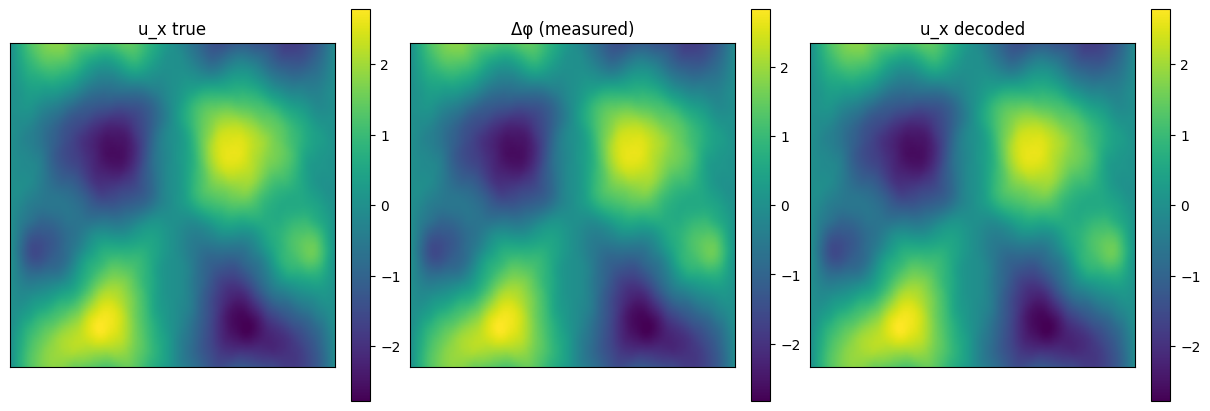

[decode] u_x  MAE=1.420e-07, RMSE=1.916e-07


In [8]:
# === Simplest PC-MRI with DeepInverse.MRI (single-coil, fully sampled) ===
import numpy as np, torch, matplotlib.pyplot as plt
import deepinv as dinv

# ---- Inputs: your velocity field (use flow_u for one direction) ----
assert "flow_u" in globals(), "Need flow_u defined."
vx_np = np.asarray(flow_u)                       # (Ny, Nx)
Ny, Nx = vx_np.shape

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fdtype, cdtype = torch.float32, torch.complex64

# Torch tensors (B=1, C=1, H, W)
vx = torch.from_numpy(vx_np).to(device=device, dtype=fdtype)[None, None, ...]
S0 = torch.ones_like(vx, dtype=cdtype)          # baseline complex magnitude (anatomy = 1)

# ---- Physics (standard notation) ----
gamma = 2.675e8          # rad/s/T (1H)
target_peak_phase = 0.9*np.pi
vmax = float(np.max(np.abs(vx_np)) or 1.0)
m1   = target_peak_phase / (2.0 * gamma * vmax)  # T·s^2/m, avoids wraps but keeps sensitivity
print(f"m1 = {m1:.3e} T·s²/m,  2γm1 = {2*gamma*m1:.2e} rad/(m/s)")

# ---- Helpers: complex <-> DeepInverse 2-channel real ----
def c2r(xc):  # (B,1,H,W) complex -> (B,2,H,W) real
    return torch.view_as_real(xc.squeeze(1)).permute(0,3,1,2).contiguous()
def r2c(x2):  # (B,2,H,W) real    -> (B,1,H,W) complex
    return torch.view_as_complex(x2.permute(0,2,3,1).contiguous()).unsqueeze(1)

# ---- IMAGE-SPACE ENCODE (this is PC-MRI physics) ----
phi = torch.exp(1j * gamma * m1 * vx)           # e^{+i γ m1 v}
I_pos = S0 * phi                                # + encode
I_neg = S0 * torch.conj(phi)                    # − encode

# ---- DeepInverse MRI operator: fully sampled single-coil FFT ----
mask = torch.ones(Ny, Nx, dtype=torch.bool, device=device)   # fully sampled
mri  = dinv.physics.MRI(img_size=(Ny, Nx), mask=mask, device=device)

# Forward to k-space and back (zero-filled adjoint recon)
Y_pos = mri.A(c2r(I_pos))                       # k-space of + encode
Y_neg = mri.A(c2r(I_neg))
I_pos_zf = r2c(mri.A_adjoint(Y_pos))            # image-space adjoint (iFFT)
I_neg_zf = r2c(mri.A_adjoint(Y_neg))

# ---- Measured phase difference and velocity decode ----
dphi = torch.angle(I_pos_zf * torch.conj(I_neg_zf)).squeeze().cpu().numpy()   # ≈ 2 γ m1 v
v_hat = dphi / (2.0 * gamma * m1)

# ---- Plot truth, phase encode, and decoded velocity ----
vx_true = vx.squeeze().cpu().numpy()
fig, axes = plt.subplots(1,3, figsize=(12,4), constrained_layout=True, sharex=True, sharey=True)
im0 = axes[0].imshow(vx_true, origin='lower'); axes[0].set_title('u_x true');      plt.colorbar(im0, ax=axes[0])
im1 = axes[1].imshow(dphi,    origin='lower'); axes[1].set_title('Δφ (measured)'); plt.colorbar(im1, ax=axes[1])
im2 = axes[2].imshow(v_hat,   origin='lower'); axes[2].set_title('u_x decoded');   plt.colorbar(im2, ax=axes[2])
for ax in axes: ax.set_xticks([]); ax.set_yticks([])
plt.show()

mae = np.mean(np.abs(v_hat - vx_true)); rmse = np.sqrt(np.mean((v_hat - vx_true)**2))
print(f"[decode] u_x  MAE={mae:.3e}, RMSE={rmse:.3e}")
